In [2]:
from csbdeep.models import Config, CARE
from n2v.models import N2V
from metrics import metrics_psnr, metrics_ssim, metrics_lpips
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
import seaborn as sns
from skimage.metrics import structural_similarity

In [3]:
planaria_data = np.load('/Users/schaudhary/siva_projects/Denoising_Planaria/train_data/data_label.npz')
X = planaria_data['X']
Y = planaria_data['Y']

# Test Care 2d predictions

In [79]:
axes = 'YXC'
model_name = 'care_planaria_2D'
model_basedir = '/Users/schaudhary/siva_projects/DifFace/baseline_denoising/care/'
model = CARE(config=None, name=model_name, basedir=model_basedir)

Loading network weights from 'weights_best.h5'.


In [80]:
curr_X = np.transpose(X[2000], [1, 2, 3, 0])
curr_Y = np.transpose(Y[2000], [1, 2, 3, 0])
restored = []
for z in range(curr_X.shape[0]):
    restored.append(model.predict(curr_X[z], axes))

1/1 [==============================] - 0s 25ms/step


In [38]:
[(np.max(restored[z]), np.min(restored[z])) for z in range(curr_X.shape[0])]

[(0.40405032, 0.08027993),
 (0.34125963, -0.043029346),
 (0.78975683, 0.038745314),
 (1.526416, 0.043929838),
 (1.9790854, -0.041230783),
 (2.3126242, -0.016492125),
 (1.8925428, 0.05879309),
 (2.0023806, 0.010248501),
 (2.3349323, -0.014369601),
 (2.347998, -0.008981369),
 (0.93918914, 0.024096794),
 (0.57839423, 0.05011391),
 (0.34834486, 0.04444321),
 (0.4121996, 0.0011384543),
 (0.36419332, 0.023131823),
 (0.32464582, 0.0015096888)]

In [81]:
tifffile.imwrite('/Users/schaudhary/siva_projects/DifFace/baseline_denoising/care/care_planaria_2D/predictions/train_idx1000_z14.tif', restored[14])

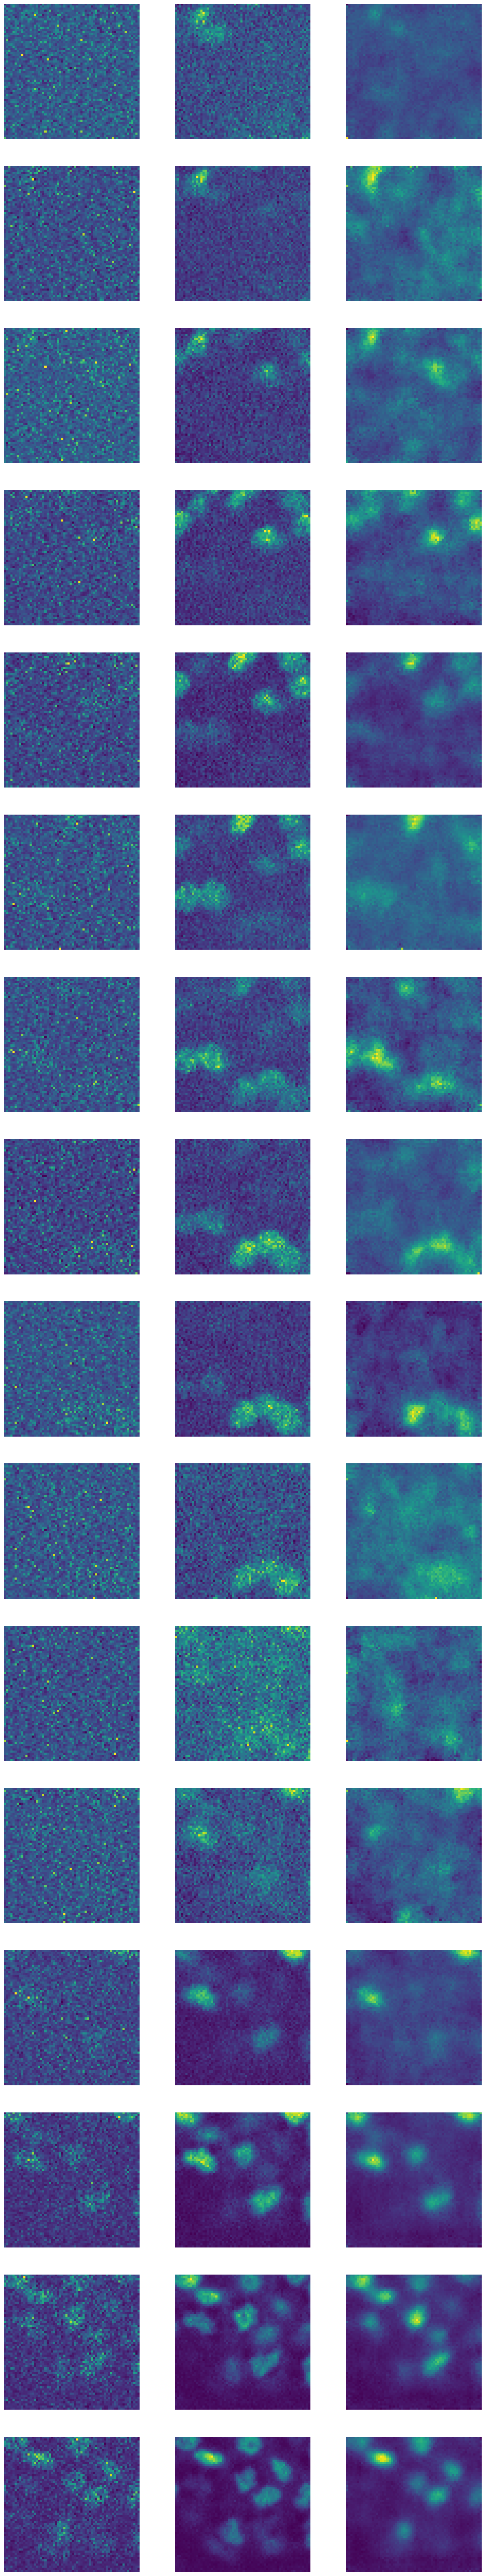

In [70]:
fig, ax = plt.subplots(curr_X.shape[0], 3, figsize=(15, 5*curr_X.shape[0]))
for z in range(curr_X.shape[0]):
    ax[z, 0].imshow(curr_X[z, :, :, 0])
    ax[z, 1].imshow(curr_Y[z, :, :, 0])
    ax[z, 2].imshow(restored[z][:, :, 0])
    ax[z, 0].axis('off')
    ax[z, 1].axis('off')
    ax[z, 2].axis('off')

In [6]:
def collate_noisy_gt(noisy_paths, gt_paths):
    data = {X:Y for X, Y in zip(noisy_paths, gt_paths)}
    return data

def load_planaria_test_data():
    test_imgs_X1 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_1/*.tif')
    test_imgs_X2 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_2/*.tif')
    test_imgs_X3 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_3/*.tif')
    test_imgs_Y = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/GT/*.tif')
    data = {}
    data.update(collate_noisy_gt(test_imgs_X1, test_imgs_Y))
    data.update(collate_noisy_gt(test_imgs_X2, test_imgs_Y))
    data.update(collate_noisy_gt(test_imgs_X3, test_imgs_Y))
    return data

In [7]:
data = load_planaria_test_data()

axes = 'YX'
model_name = 'care_planaria_2D'
model_basedir = '/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/baseline_denoising/care'
model = CARE(config=None, name=model_name, basedir=model_basedir)

Loading network weights from 'weights_best.h5'.


1/1 [==============================] - 4s 4s/step


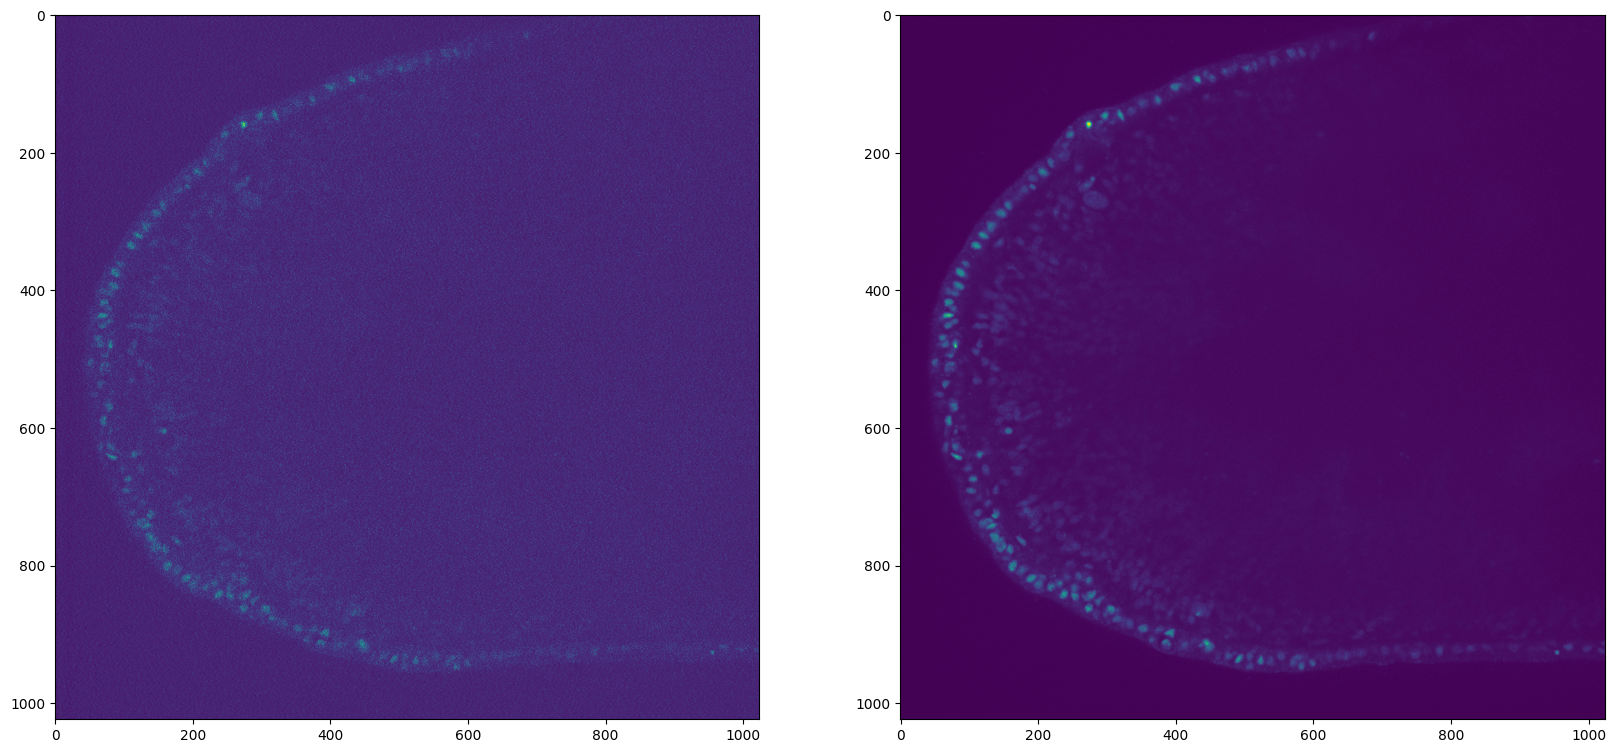

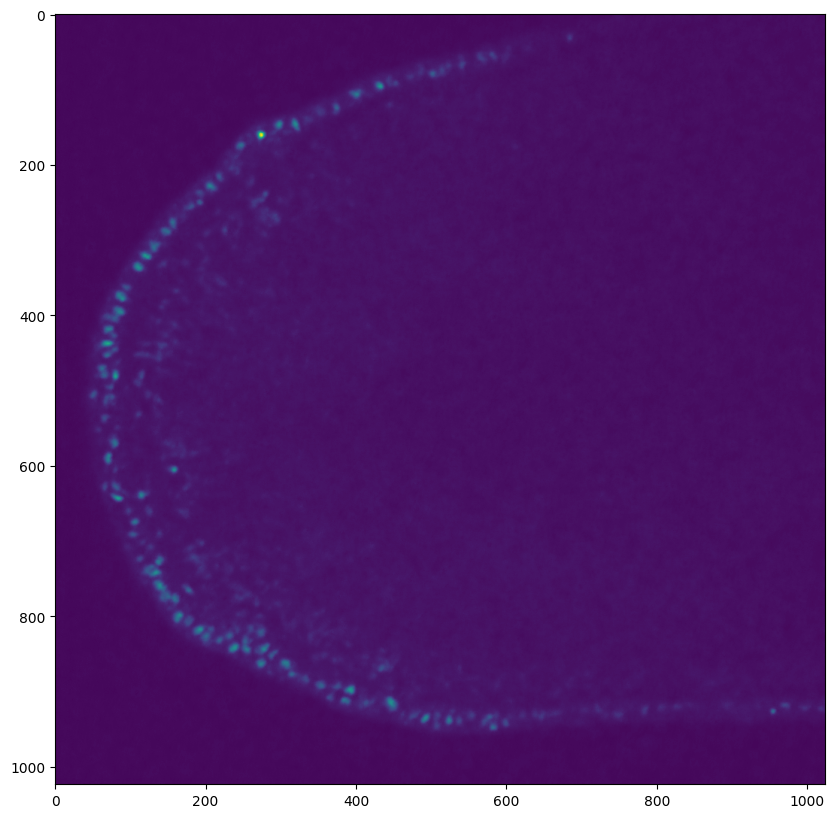

In [22]:
noisy_imgs = list(data.keys())
idx = 0
X = tifffile.imread(noisy_imgs[idx]).astype(np.float32)
Y = tifffile.imread(data[noisy_imgs[idx]]).astype(np.float32)

z = 0
restored = model.predict(X[z], axes)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X[z])
ax[1].imshow(Y[z])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(restored)

In [9]:
import torch
from pytorch_fid_master.src.pytorch_fid.fid_score import calculate_frechet_distance, calculate_activation_statistics
from pytorch_fid_master.src.pytorch_fid.inception import InceptionV3

In [23]:
def metrics_fid(img1, img2):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    batch_size=50
    dims=2048
    num_workers=1
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device).float()
    m1, s1 = calculate_activation_statistics([img1], model, batch_size=batch_size, dims=dims,
                                    device=device, num_workers=num_workers)
    m2, s2 = calculate_activation_statistics([img2], model, batch_size=batch_size, dims=dims,
                                    device=device, num_workers=num_workers)
    score = calculate_frechet_distance(m1, s1, m2, s2)
    return score

In [24]:
fid_score = metrics_fid(img1=restored, img2=Y[z])

100%|██████████| 1/1 [01:46<00:00, 106.74s/it]


100%|██████████| 1/1 [01:46<00:00, 106.68s/it]


In [25]:
fid_score

741783318.3216162

In [28]:
psnr_score = metrics_psnr(img1=restored, img2=Y[z], max_value=1)
ssim_score = metrics_ssim(img1=restored, img2=Y[z])
lpips_score = metrics_lpips(img1=restored, img2=Y[z])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


# test N2V predictions

In [4]:
axes = 'YXC'
model_name = 'N2V_planaria'
model_basedir = '/Users/schaudhary/siva_projects/DifFace/baseline_denoising/N2V/'
model = N2V(config=None, name=model_name, basedir=model_basedir)

Loading network weights from 'weights_best.h5'.


In [5]:
curr_X = np.transpose(X[2000], [1, 2, 3, 0])
curr_Y = np.transpose(Y[2000], [1, 2, 3, 0])
restored = []
for z in range(curr_X.shape[0]):
    restored.append(model.predict(curr_X[z], axes))

1/1 [==============================] - 0s 29ms/step


In [78]:
tifffile.imwrite('/Users/schaudhary/siva_projects/DifFace/baseline_denoising/N2V/N2V_planaria/predictions/train_idx1000_z14.tif', restored[14])

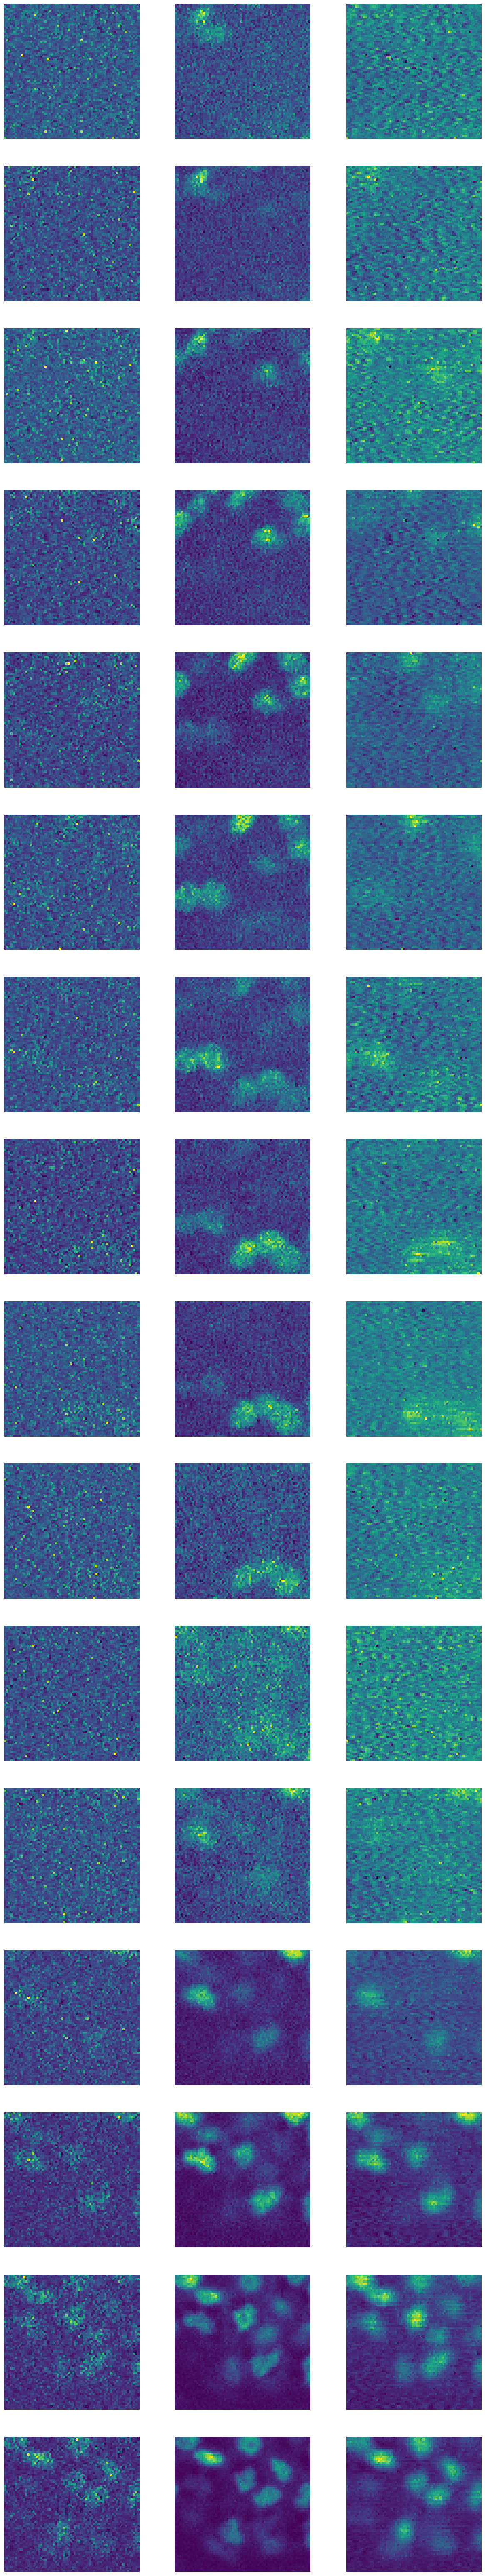

In [6]:
fig, ax = plt.subplots(curr_X.shape[0], 3, figsize=(15, 5*curr_X.shape[0]))
for z in range(curr_X.shape[0]):
    ax[z, 0].imshow(curr_X[z, :, :, 0])
    ax[z, 1].imshow(curr_Y[z, :, :, 0])
    ax[z, 2].imshow(restored[z][:, :, 0])
    ax[z, 0].axis('off')
    ax[z, 1].axis('off')
    ax[z, 2].axis('off')

(array([ 44., 234., 404., 369., 370., 327., 299., 250., 229., 170., 149.,
        136.,  93.,  73.,  83.,  42.,  48.,  40.,  37.,  25.,  27.,  25.,
         24.,  16.,  20.,  23.,  19.,  21.,  23.,  21.,  24.,  18.,  24.,
         26.,  19.,  19.,  21.,  24.,  25.,  23.,  22.,  14.,  13.,  22.,
         14.,  11.,  10.,   8.,   5.,  12.,  11.,   8.,   5.,  11.,   8.,
          7.,   6.,   7.,   3.,   3.,   2.,   2.,   0.,   2.,   1.,   2.,
          2.,   3.,   0.,   0.,   0.,   1.,   1.,   3.,   0.,   2.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   0.,   4.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.04824888, 0.07738512, 0.10652136, 0.13565761, 0.16479383,
        0.19393007, 0.22306632, 0.25220257, 0.28133881, 0.31047505,
        0.33961126, 0.3687475 , 0.39788374, 0.42701998, 0.45615622,
        0.48529246, 0.51442873, 0.54356498, 0.57270122, 0.60183746,
        0.6309737 , 0.66010994, 0.68924618, 0.

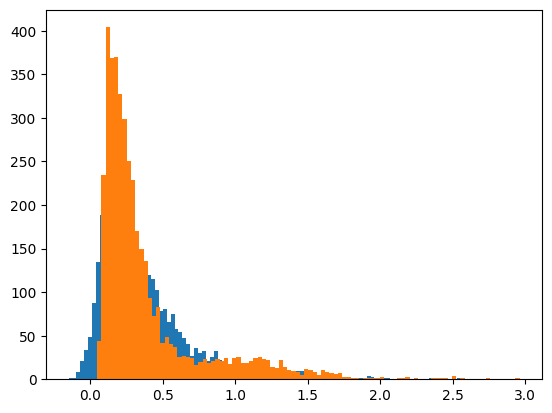

In [14]:
fig, ax = plt.subplots(1, 1)
plt.hist(np.reshape(curr_X[-1], [-1, 1]), bins=100)
plt.hist(np.reshape(curr_Y[-1], [-1, 1]), bins=100)

(array([  5.,   3.,  12.,  35.,  81., 129., 206., 275., 284., 280., 245.,
        221., 223., 192., 154., 166., 139., 119.,  95.,  73.,  74.,  70.,
         58.,  47.,  53.,  46.,  34.,  38.,  40.,  38.,  27.,  23.,  29.,
         19.,  28.,  25.,  27.,  21.,  21.,  21.,  27.,  20.,  21.,  25.,
         15.,  16.,  19.,  24.,  14.,  13.,  15.,  17.,  11.,  11.,  14.,
         17.,   5.,   7.,  10.,  13.,   6.,   4.,  11.,   3.,   9.,   7.,
          4.,   6.,   9.,   4.,   5.,   2.,   6.,   5.,   3.,   1.,   1.,
          3.,   3.,   1.,   1.,   3.,   0.,   0.,   2.,   0.,   2.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.10349505, 0.11727146, 0.13104787, 0.14482428, 0.1586007 ,
        0.17237711, 0.18615353, 0.19992994, 0.21370636, 0.22748277,
        0.24125919, 0.25503561, 0.268812  , 0.28258842, 0.29636484,
        0.31014127, 0.32391766, 0.33769408, 0.3514705 , 0.36524692,
        0.37902331, 0.39279974, 0.40657616, 0.

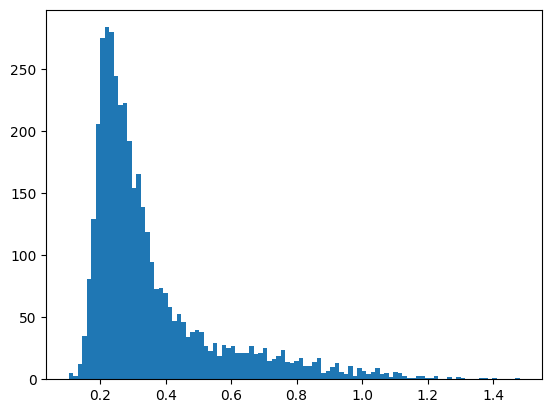

In [11]:
plt.hist(np.reshape(restored[-1], [-1, 1]), bins=100)

In [13]:
metrics_ssim(restored[-1][:, :, 0], curr_Y[-1][:, :, 0])

0.6835585457453334